In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
classifier = Sequential()
classifier.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.15))
classifier.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'softmax'))

classifier.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [123]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
datagen = ImageDataGenerator(rescale=1. / 255)
itr =  datagen.flow_from_directory(
            './data_set_tile',
            target_size=(64,64),
            batch_size=1868,
            class_mode='categorical')
X, y = itr.next()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [124]:
from tile_classifier import load_data
folder = './data_set_tile'
X_train,X_test,y_train,y_test = load_data(folder)
classifier.fit(X_train, y_train, epochs=5, batch_size=X_train.shape[0]//20,verbose = 1)
classifier.save_weights('model.h5') 
classifier.load_weights('model.h5')

In [125]:
import cv2
import numpy as np
img = cv2.imread('./testy/002.jpg')

In [126]:
def get_contour(img):
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey,(7,7),0)
    edges = cv2.Canny(blur,50,100,apertureSize = 3)
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(edges,kernel,iterations = 2)
    contour_img, contours, hierarchy = cv2.findContours(
                                            dilation, 
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key = cv2.contourArea)
    contour_img = img.copy()
    contour_img = cv2.drawContours(contour_img, [cnt], 0, (0,255,0), 3)
    return contour_img, cnt

contour_img, cnt = get_contour(img)

In [127]:
def get_points(cnt):
    epsilon = 0.01*cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    x_center = np.mean(approx[:,:,0])
    y_center = np.mean(approx[:,:,1])

    #sorting
    pts = np.zeros((4,2))
    for x in approx:
        for X, Y in x:
            if(X<x_center and Y<y_center):
                pts[0,0] = X
                pts[0,1] = Y
            if(X<x_center and Y>y_center):
                pts[1,0] = X
                pts[1,1] = Y
            if(X>x_center and Y>y_center):
                pts[2,0] = X
                pts[2,1] = Y
            if(X>x_center and Y<y_center):
                pts[3,0] = X
                pts[3,1] = Y
    size = max(approx.flatten()) - min(approx.flatten())
    return pts, size

pts, size = get_points(cnt)

In [128]:
def warp_image(img, pts, size):
    pts = np.float32(pts)
    pts_sqr = np.float32([[0,0],[0,size],[size,size],[size,0]])
    M = cv2.getPerspectiveTransform(pts,pts_sqr)
    warped_img = cv2.warpPerspective(img,M,(size,size))
    return warped_img
board = warp_image(img, pts, size)
warped_img = board[...,::-1]

In [129]:
def slice_image(image):
    slices = list()
    samples_x = np.linspace(0,image.shape[0],16, dtype=np.int)
    samples_y = np.linspace(0,image.shape[1],16,dtype=np.int)
    for x_start, x_end in zip(samples_x, samples_x[1:]):
        for y_start, y_end in zip(samples_y, samples_y[1:]):
            slices.append(image[x_start:x_end,y_start:y_end])
    return slices


In [130]:
from skimage.transform import resize
slices = slice_image(warped_img)
indexes = list()
for slice_ in slices:
    scaled_img = resize(slice_,(64,64,3),mode='reflect')
    img = np.expand_dims(scaled_img, axis = 0)
    prediction = classifier.predict(img)
    indexes.append(np.argmax(prediction.flatten()))
arr = np.array(indexes).reshape(15,15)

In [131]:
print(arr)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


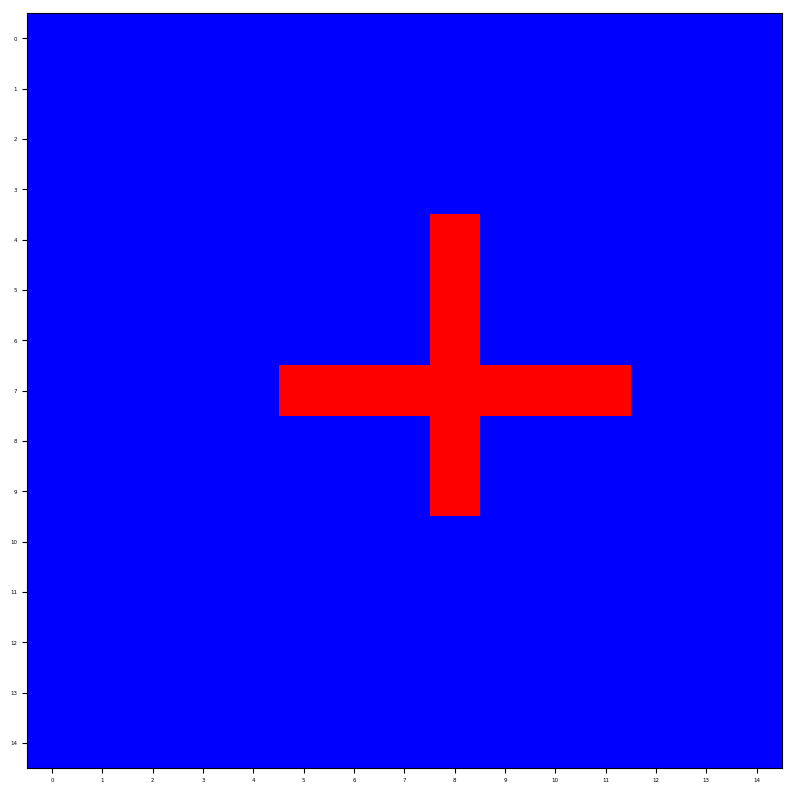

In [132]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10),dpi= 100)
ax = fig.add_subplot(1,1,1)
ax.set_xticks(range(0,15))                                                       
ax.set_yticks(range(0,15))
ax.imshow(arr, cmap = 'bwr')
plt.show()

In [18]:
tile_indexes = [i for i, x in enumerate(indexy) if x == 1]